In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from evaluator import CropOffsetFilter
from metrics import CovarianceWeightedAverage 
from training_models import AutoencoderEnsemble as RCCTraining
from monitor_models import RepresentationCrossCovariances as RCCMonitoring
from directory import get_checkpoint_path
from kfold_tester import KFoldTester

In [11]:
def plot_waveform(x, spec, title, t, x_axis_label="", xaxis_loc="center"):
    shapex = np.shape(x)
    if len(shapex) == 1:
        channels = 1
        x = np.expand_dims(x, axis=1)
    else:
        channels = shapex[1]

    waveforms = gridspec.GridSpecFromSubplotSpec(
        channels,
        1,
        subplot_spec=spec,
        wspace=0.3,
        hspace=0.2,
    )

    for i in range(channels):
        ax = plt.subplot(waveforms[i, 0])
        
        if i == 0:
            ax.set_title(title, loc="left")
        
        if i == channels - 1:
            ax.set_xlabel(x_axis_label, loc=xaxis_loc)
            ax.xaxis.set_visible(True)
        else:
            ax.xaxis.set_visible(False)

        ax.plot(t, x[:, i], linewidth=0.5, scalex=0.5)

def plot_feature(x, vmin, vmax, spec, title, x_axis_vis=True, x_axis_label="", y_axis_vis=True, y_axis_label="", xaxis_loc="center", yaxis_loc="center"):
    ax = plt.subplot(spec)
    ax.set_xlabel(x_axis_label, loc=xaxis_loc)
    ax.set_ylabel(y_axis_label, loc=yaxis_loc)
    #ax.xaxis.set_visible(x_axis_vis)
    ax.yaxis.set_visible(y_axis_vis)

    ax.set_xticklabels(["", "0", "15", "30"])
    ax.set_yticklabels(["", "64", "0"])

    ax.set_title(title, loc="left")
    im = ax.imshow(np.transpose(x), vmin=vmin, vmax=vmax, cmap="magma", interpolation='nearest', aspect=1)
    return ax, im

def plot_autocovariance_sample(x, f, y, xcov, fcov, ycov):
    fig = plt.figure(figsize=(8,5))
    gs_main = gridspec.GridSpec(3, 2, wspace=0.25, hspace=0.5, height_ratios=[2, 2, 2])
    
    gs_x_waveform = gs_main[0, 0]
    gs_representation = gs_main[1, 0]
    gs_y_waveform = gs_main[2, 0]

    gs_x_covariance = gs_main[0, 1]
    gs_representation_covariance = gs_main[1, 1]
    gs_y_covariance = gs_main[2, 1]

    labels = ["i)", "ii)", "iii)", "iv)", "v)", "vi)", "vii)", "viii)"]
    label_idx = 0

    plot_waveform(x, gs_x_waveform, labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    plot_waveform(xcov, gs_x_covariance, labels[label_idx], t=np.linspace(-15, 15, 3000))
    label_idx += 1
    ax, im = plot_feature(f, np.min(np.array(f)), np.max(np.array(f)), gs_representation, "{}".format(labels[label_idx]))
    label_idx += 1
    plot_waveform(fcov, gs_representation_covariance, labels[label_idx], t=np.linspace(-15, 15, 94))
    label_idx += 1
    plot_waveform(y, gs_y_waveform, labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    plot_waveform(ycov, gs_y_covariance, labels[label_idx], t=np.linspace(-15, 15, 3000))
    
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.1, shrink=1, aspect=10, fraction=0.2)
    gs_main.tight_layout(fig, pad=0.5)

def plot_augmentation_crosscov_sample(xa, xb, fa, fb, ya, yb, xcov, fcov, ycov):
    fig = plt.figure(figsize=(8,5))
    gs_main = gridspec.GridSpec(3, 3, wspace=0.25, hspace=0.5, height_ratios=[2, 2, 2])
    
    gs_xa, gs_xb, gs_xcov = (gs_main[0, 0], gs_main[0, 1], gs_main[0, 2])
    gs_fa, gs_fb, gs_fcov = (gs_main[1, 0], gs_main[1, 1], gs_main[1, 2])
    gs_ya, gs_yb, gs_ycov = (gs_main[2, 0], gs_main[2, 1], gs_main[2, 2])

    labels = ["i)", "ii)", "iii)", "iv)", "v)", "vi)", "vii)", "viii)", "ix", "x"]
    label_idx = 0

    axes = []
    plot_waveform(xa, gs_xa, labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    plot_waveform(xb, gs_xb, labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    plot_waveform(xcov, gs_xcov, labels[label_idx], t=np.linspace(-15, 15, 3000))
    label_idx += 1
    ax, im = plot_feature(fa, np.min(np.array(fa)), np.max(np.array(fa)), gs_fa, "{}".format(labels[label_idx]))
    axes.append(ax)
    label_idx += 1
    ax, im = plot_feature(fb, np.min(np.array(fb)), np.max(np.array(fb)), gs_fb, "{}".format(labels[label_idx]), y_axis_vis=False)
    axes.append(ax)
    label_idx += 1
    plot_waveform(fcov, gs_fcov, labels[label_idx], t=np.linspace(-15, 15, 94))
    label_idx += 1
    plot_waveform(ya, gs_ya, labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    plot_waveform(yb, gs_yb, labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    plot_waveform(ycov, gs_ycov, labels[label_idx], t=np.linspace(-15, 15, 3000))
    
    cbar = plt.colorbar(im, ax=axes, orientation="vertical", pad=0.1, shrink=1, aspect=10, fraction=0.2)
    gs_main.tight_layout(fig, pad=0.5)

def plot_ensemble_sample(latent_cov, waveforms=[], features=[]):
    fig = plt.figure(figsize=(8,5))
    gs_main = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.25, height_ratios=[2, 1, 1])
    gs_waveform = gridspec.GridSpecFromSubplotSpec(1, len(waveforms), gs_main[0, 0], wspace=0.25, hspace=0.25)
    gs_representations = gridspec.GridSpecFromSubplotSpec(1, len(features), gs_main[1, 0], wspace=0.25, hspace=0.25)
    gs_covariance = gs_main[2, 0]

    labels = ["i)", "ii)", "iii)", "iv)", "v)", "vi)", "vii)", "viii)"]
    label_idx = 0
    plot_waveform(waveforms[0], gs_waveform[0], labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    if len(waveforms) > 1:
        plot_waveform(waveforms[1], gs_waveform[1], labels[label_idx], t=np.linspace(0, 30, 3000))
        label_idx += 1
    
    vmax = np.max(np.array(features))
    vmin = np.min(np.array(features))

    axes = []
    for i, feature in enumerate(features):
        if i > 0:
            ax, im = plot_feature(feature, vmin, vmax, gs_representations[i], "{}".format(""), y_axis_vis=False)
        else:
            ax, im = plot_feature(feature, vmin, vmax, gs_representations[i], "{}".format(labels[label_idx]))
            label_idx += 1
        axes.append(ax)

    gs_main.tight_layout(fig, pad=1.5)
    cbar = plt.colorbar(im, ax=axes, orientation="vertical", pad=0.05, shrink=1, aspect=10, fraction=0.05)
    plot_waveform(latent_cov, gs_covariance, labels[label_idx], t=np.linspace(-15, 15, 94))

In [12]:
exps = [{"name":"representation_augmentation_ensemble_30s",
        "traces_path": "./monitoring/exp_test/representation_cross_covariances/autoencoder_ensemble/training_stead/testing_stead/split0/meta.csv",
        "monitor_path": "./monitoring/exp_test/representation_cross_covariances/autoencoder_ensemble/training_stead/testing_stead/split0/epoch8_monitoredparams['x', 'fcov', 'f1'].hdf5"
     }]

curves = []
traces = []
for exp in exps:
    df_traces = pd.read_csv(exp["traces_path"])
    offset_filter = CropOffsetFilter(2.5, 2.5, 30., 100)
    metric = CovarianceWeightedAverage("fcov")
    
    vars = {}
    with h5.File(exp["monitor_path"], "r") as f:
        for key in f.keys():
            vars[key] = np.array(f[key])
            if key == "x":
                vars[key] = vars[key] / (np.std(vars[key]) + 1e-10)
            if key == "ycov":
                vars[key] = vars[key] / (3000/np.sqrt(2))
            if key == "fcov":
                vars[key] = vars[key] / 64
    
    df_no = df_traces[df_traces.label == "no"]
    df_eq = df_traces[df_traces.label == "eq"]

    df_eq = offset_filter.apply(df_eq)

    df_traces = pd.concat([df_no, df_eq]).sample(frac=1)

    for key in vars.keys():
        vars[key] = vars[key][np.array(df_traces.index), :]
    
    df_traces.reset_index(inplace=True, drop=True)
    df_traces["Cross-covariance"] = metric(vars)
    
    traces.append(df_traces)

    fpr, tpr, thresholds = roc_curve(df_traces["label"] == "eq", df_traces["Cross-covariance"])
    pre, rec, thresholds = precision_recall_curve(df_traces["label"] == "eq", df_traces["Cross-covariance"])
    curves.append({"fpr": fpr, "tpr": tpr, "pre": pre, "rec": rec, "name": exp["name"]})

/tmp/ipykernel_244302/3004651765.py:9: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(exp["traces_path"])


In [13]:
vars

{'f1': array([[[ 2.74723506e+00,  2.82153630e+00, -2.74900985e+00, ...,
           2.76154995e+00,  2.70706964e+00, -2.81441069e+00],
         [ 2.86709738e+00,  2.93747520e+00, -2.86869979e+00, ...,
           2.87982130e+00,  2.82463503e+00, -2.92986846e+00],
         [ 2.87886667e+00,  2.94767857e+00, -2.87870932e+00, ...,
           2.89105225e+00,  2.83550858e+00, -2.94041061e+00],
         ...,
         [ 3.88296008e-01,  3.86493087e-01, -3.77779961e-01, ...,
           3.81875336e-01,  3.90240550e-01, -3.78897250e-01],
         [ 3.26183975e-01,  3.25819671e-01, -3.17838609e-01, ...,
           3.22546840e-01,  3.27846885e-01, -3.19654524e-01],
         [ 3.01516473e-01,  3.02856207e-01, -2.94202030e-01, ...,
           2.98102021e-01,  3.03450227e-01, -2.97609806e-01]],
 
        [[-7.99677968e-02, -6.64514303e-02,  8.37152004e-02, ...,
          -7.69302845e-02, -8.38363767e-02,  7.02483058e-02],
         [-4.70603108e-02, -3.57195735e-02,  5.18382788e-02, ...,
          -4.57

/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


62348    no
Name: label, dtype: object
83974    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


17434    no
Name: label, dtype: object
50990    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


50226    no
Name: label, dtype: object
55106    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


112564    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])


39356    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


31517    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


21554    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


41955    no
Name: label, dtype: object
58697    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


118673    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


23810    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


83095    no
Name: label, dtype: object
22035    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


110431    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


11569    no
Name: label, dtype: object
106736    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,5))
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64",

103948    no
Name: label, dtype: object
45560    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


24369    no
Name: label, dtype: object
43249    no
Name: label, dtype: object


/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])
/tmp/ipykernel_244302/596583271.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "15", "30"])
/tmp/ipykernel_244302/596583271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


112084    no
Name: label, dtype: object
6817    no
Name: label, dtype: object


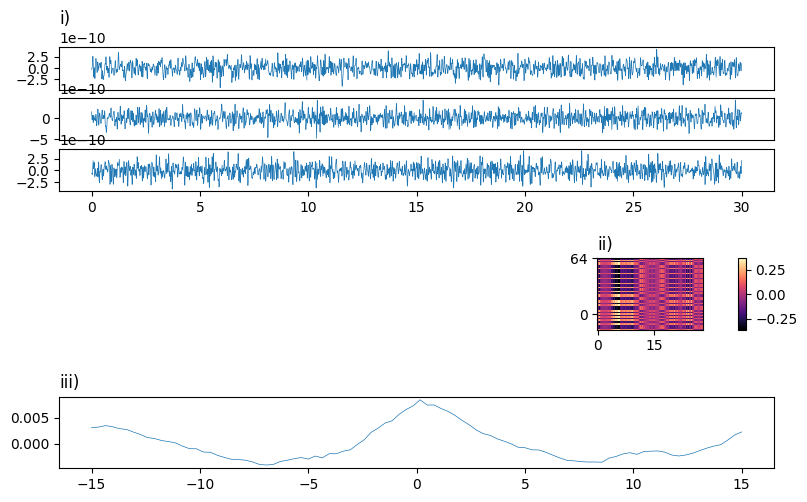

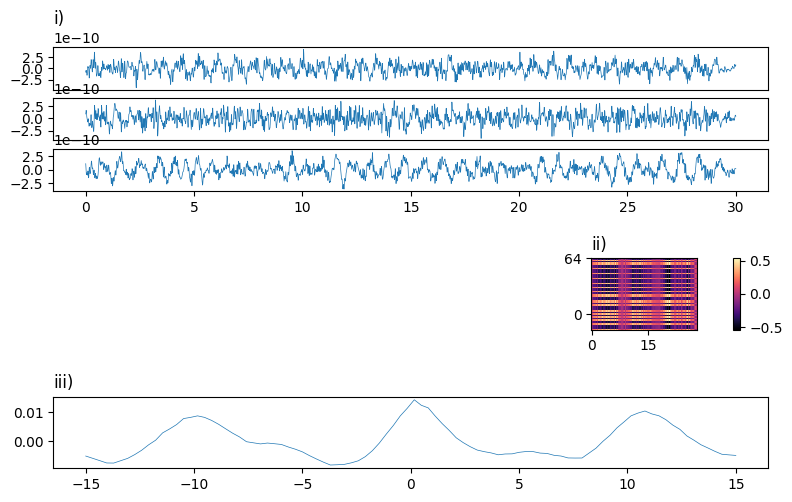

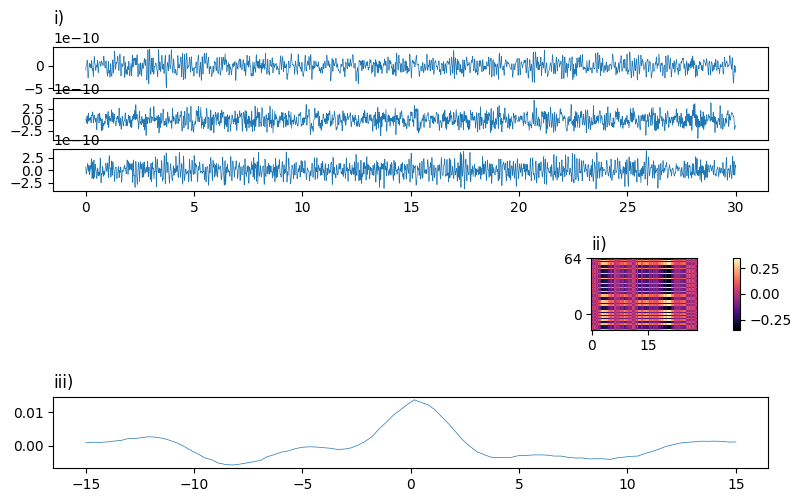

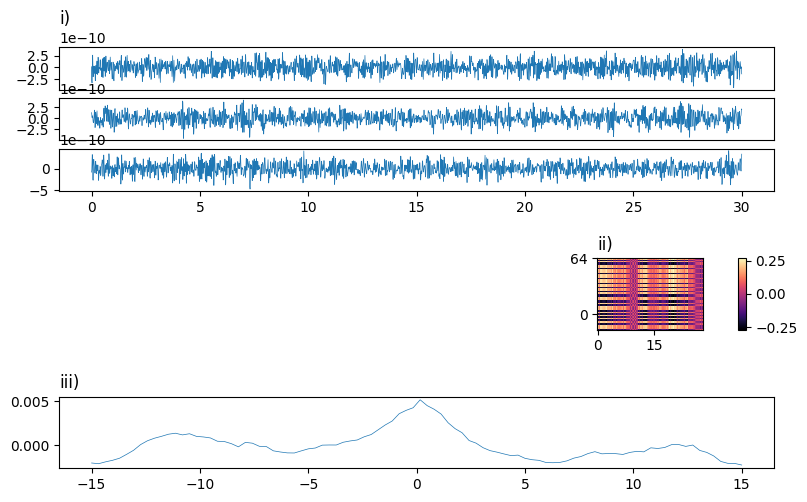

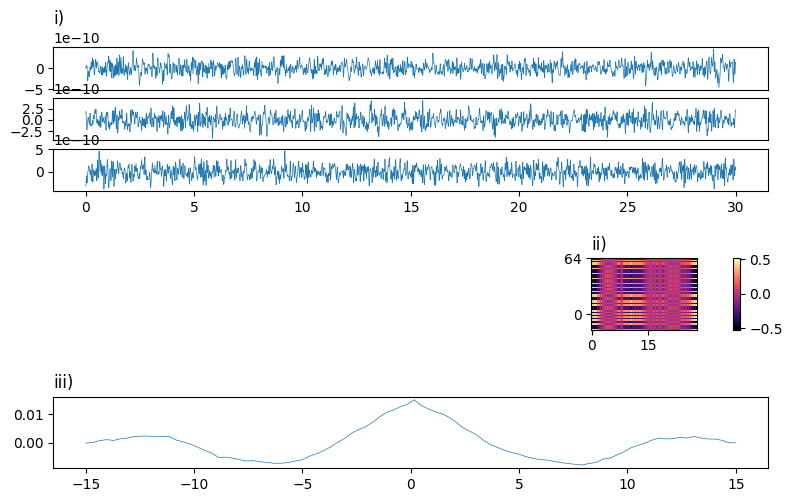

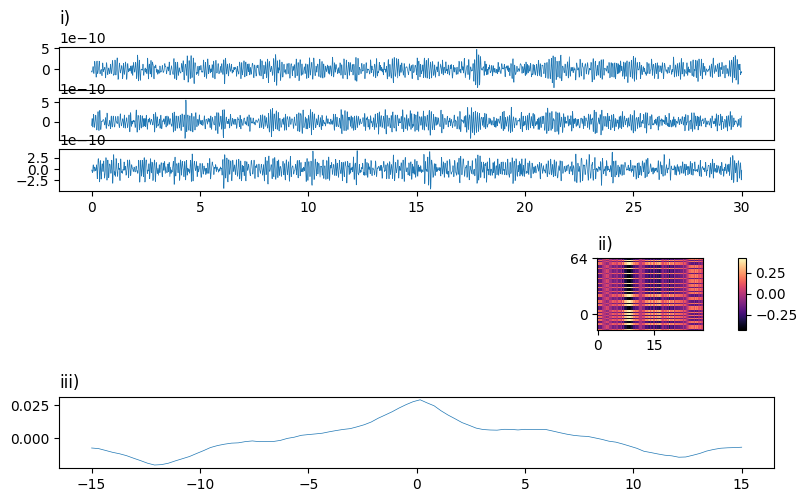

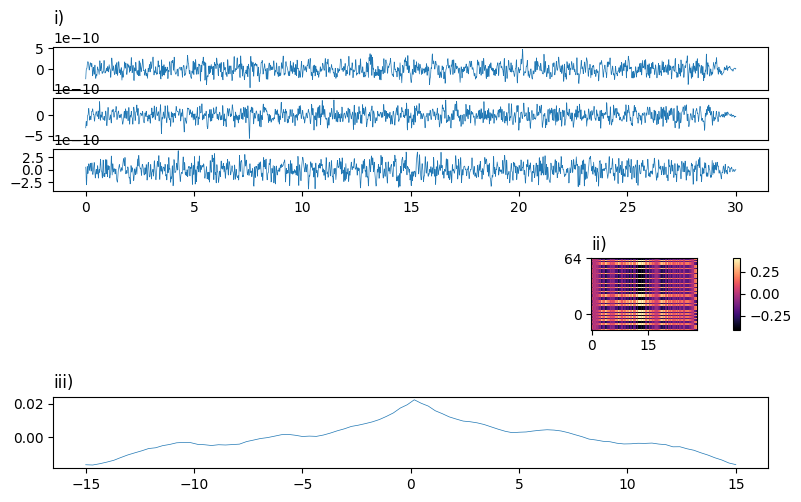

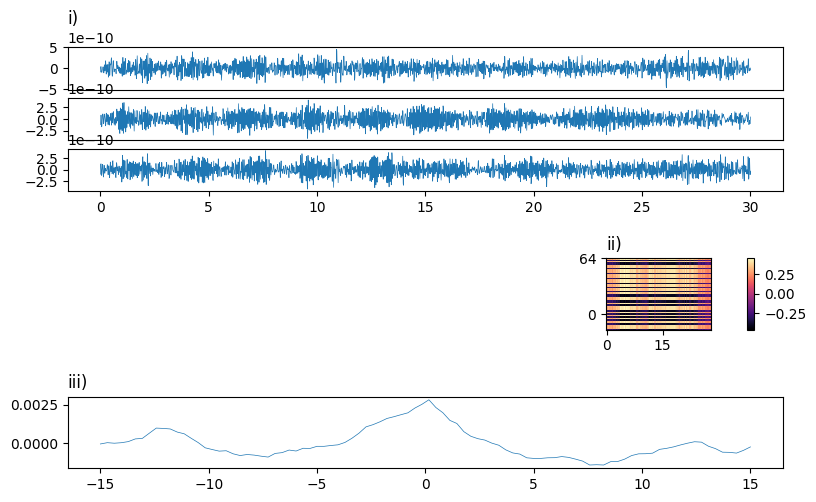

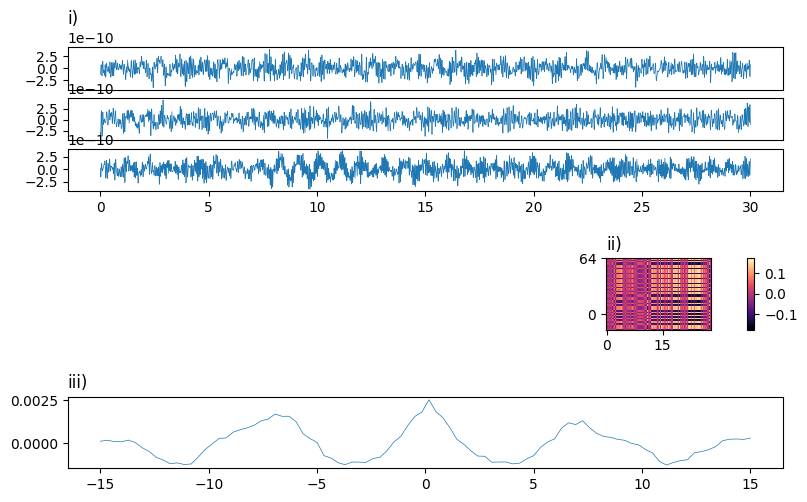

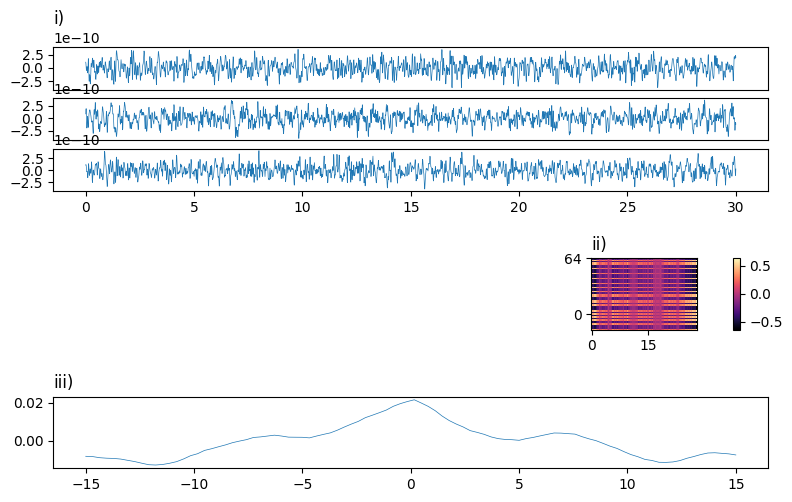

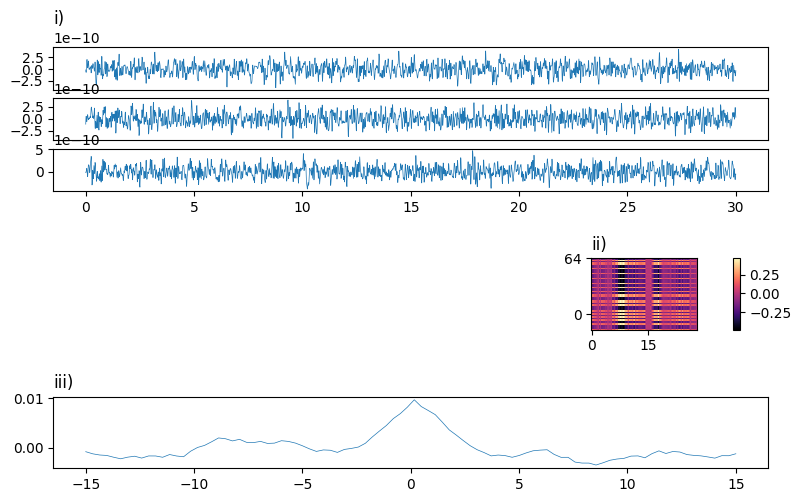

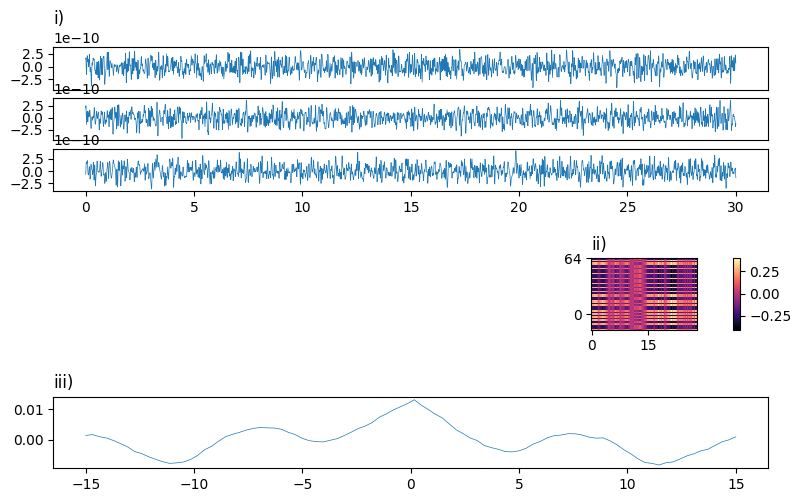

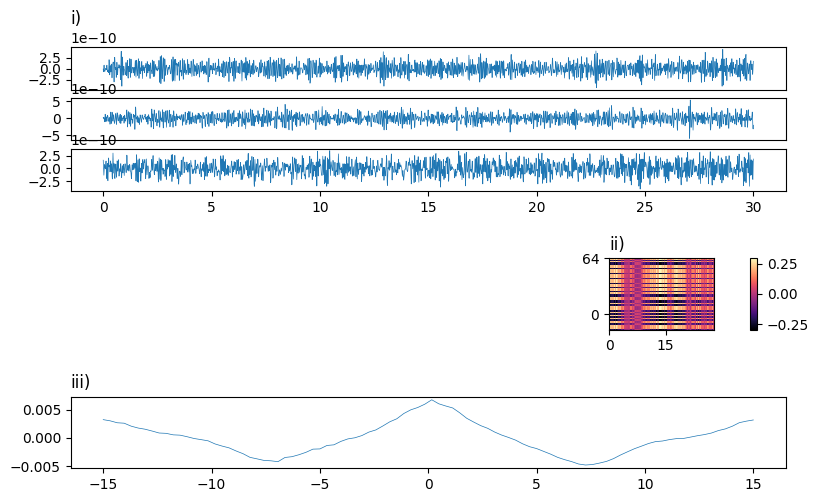

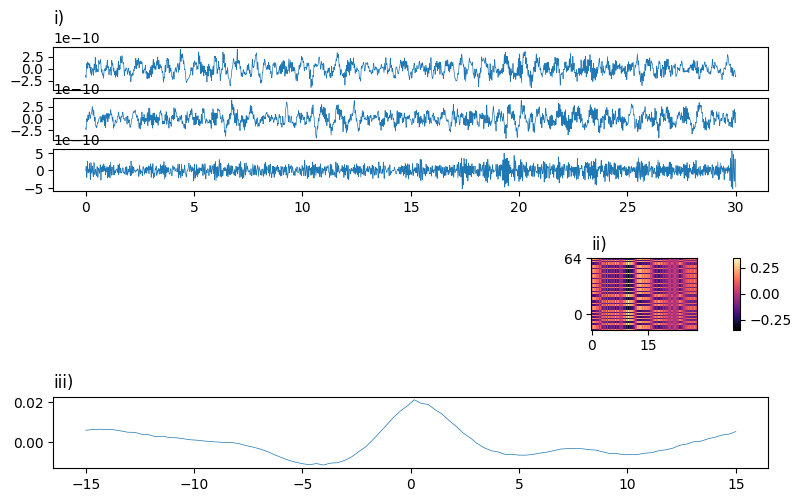

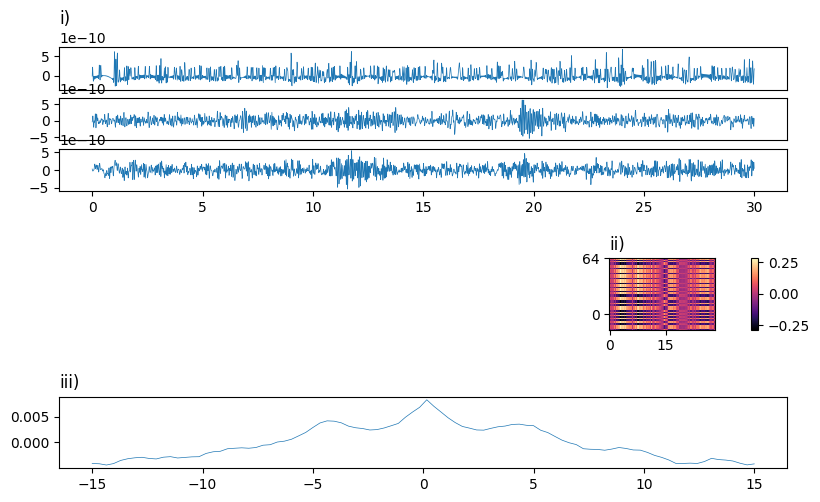

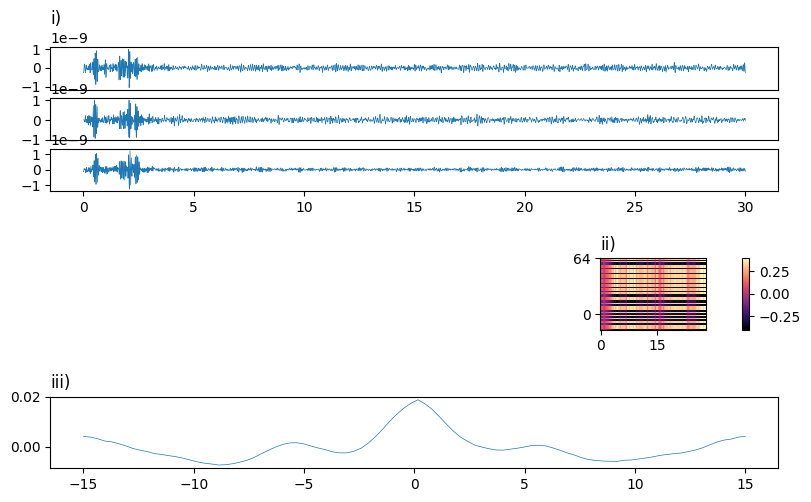

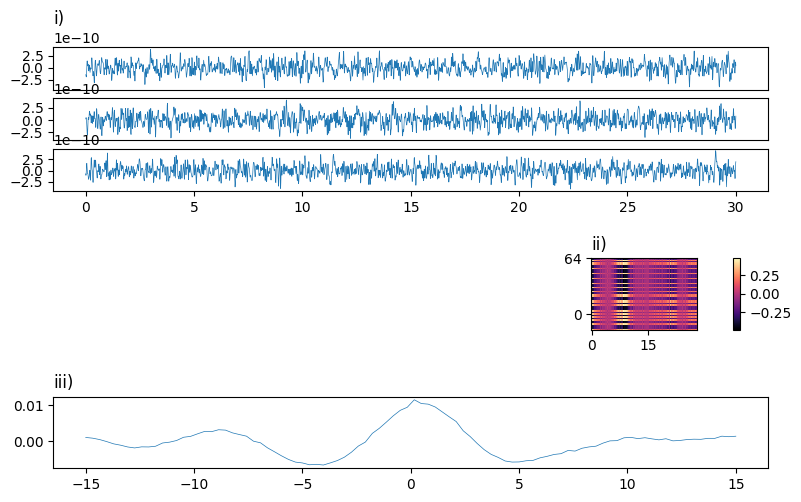

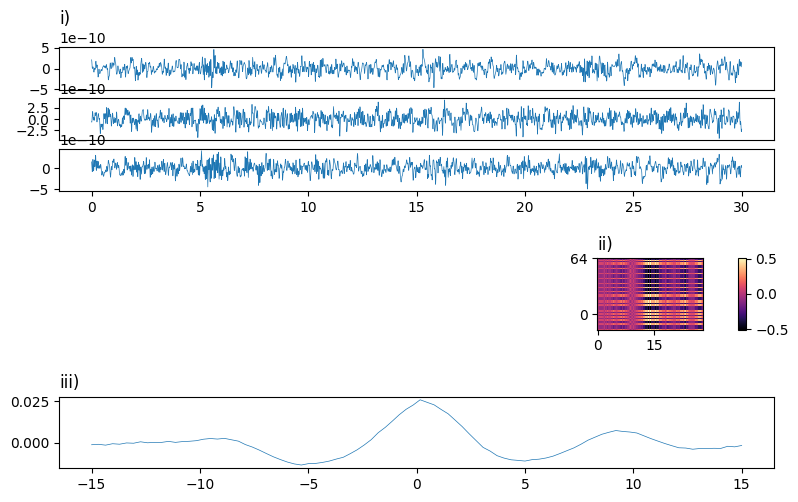

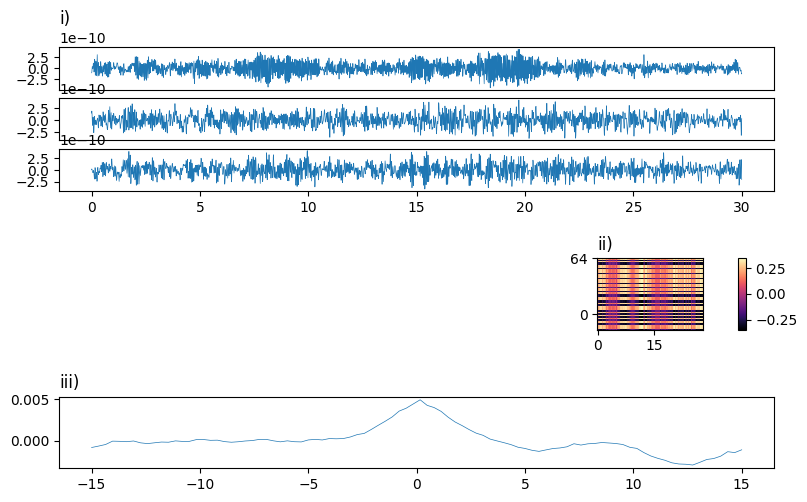

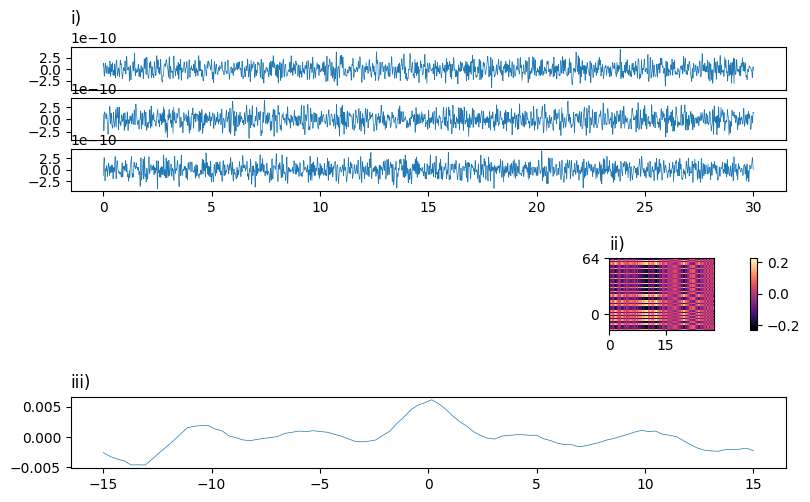

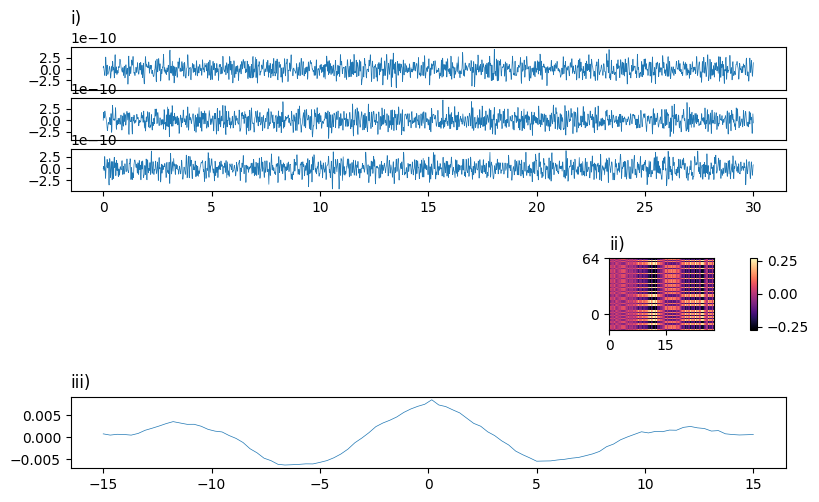

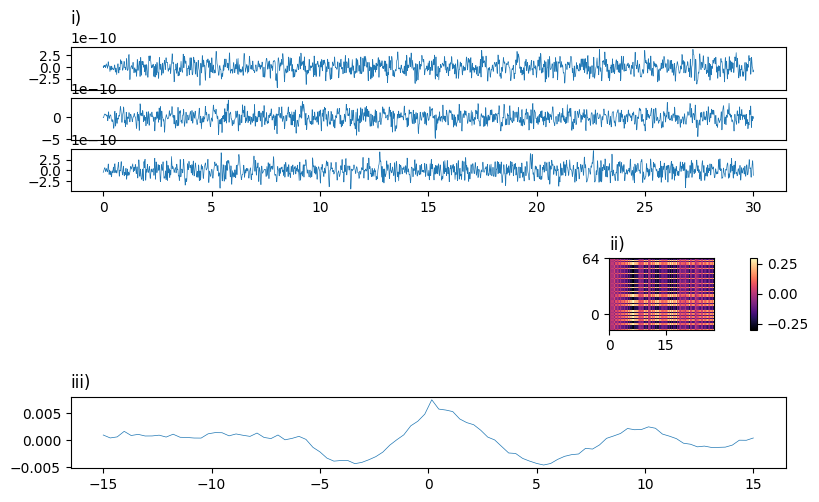

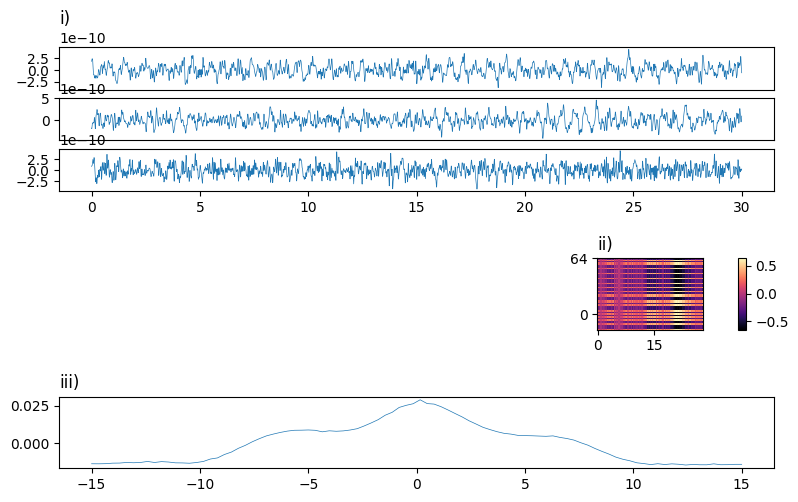

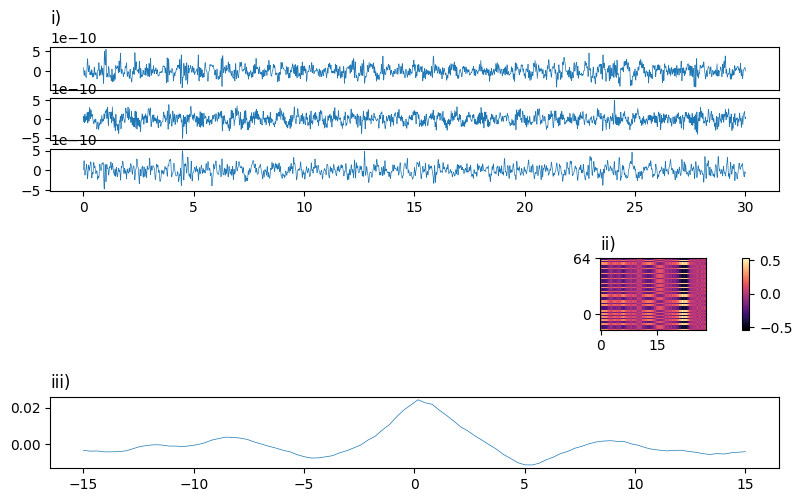

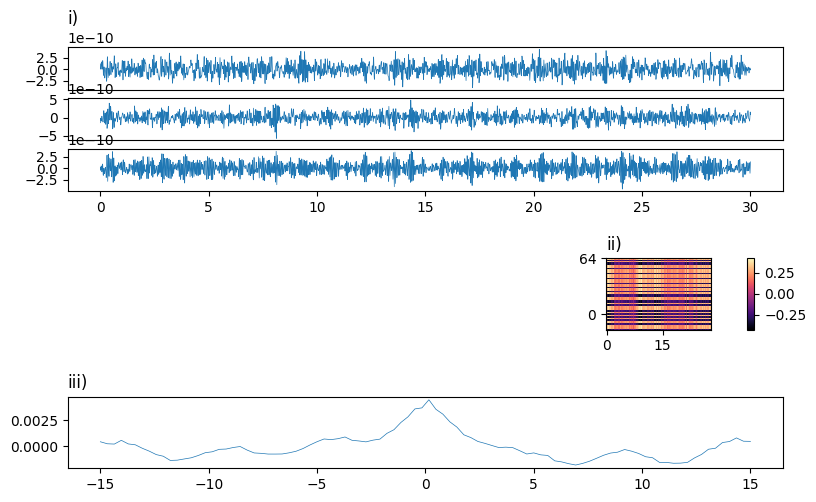

In [16]:
import random

for i in range(50):
    df_no = df_traces[df_traces["label"] == "no"]
    sample_idx = df_no.sample(1).index[0]

    if (np.max(vars["fcov"][sample_idx]) - np.min(vars["fcov"][sample_idx])) < 0.05:
        #plot_autocovariance_sample(vars["x"][sample_idx], vars["f"][sample_idx], vars["y"][sample_idx], vars["xcov"][sample_idx], vars["fcov"][sample_idx], vars["ycov"][sample_idx])
        plot_ensemble_sample(vars["fcov"][sample_idx], [vars["x"][sample_idx]], [vars["f1"][sample_idx]])
        print(df_traces.iloc[[sample_idx]]["label"])

        plt.savefig(f"./samples/no_sample{sample_idx}.pdf", dpi=600)